# Проект 12 создание модели для прогнозирования спроса на такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error #RMSE для метрики

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#from sklearn import preprocessing

#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OrdinalEncoder

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum() # ресемплирование по одному часу

data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


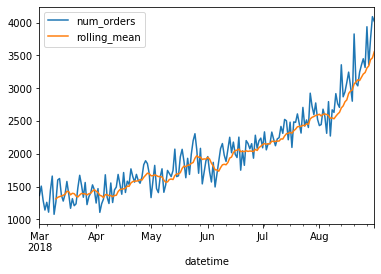

In [2]:
data_for_plot = data.copy()
data_for_plot = data_for_plot.resample('1D').sum()

data_for_plot['rolling_mean'] = data_for_plot.rolling(10).mean()
data_for_plot.rolling(10)
data_for_plot.plot()

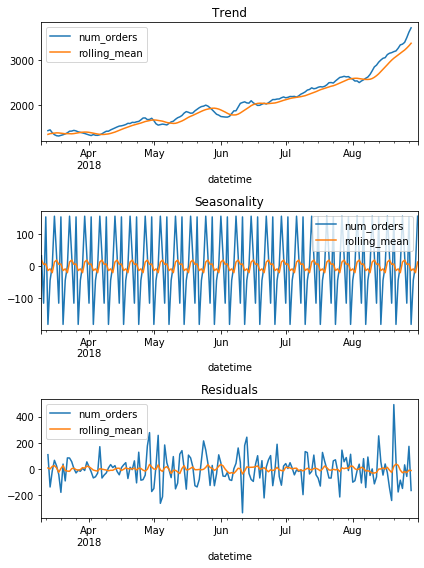

In [3]:
data_for_plot = data_for_plot.dropna()

decomposed = seasonal_decompose(data_for_plot)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Вывод:

Тренд - возрастающий, говорит о том, что заказов такси в аэропортах становится всё больше и больше с течении времени.

Из анализа сезонности, можно отметить, что среднее и стандартное отклонение не меняются.

In [4]:
def return_data_add_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['year'] = data_copy.index.year
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_copy

new_data = return_data_add_features(data,4,4)

new_data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,86.50
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,184.25
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,189.25
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,178.50


In [5]:
from IPython.display import display

def return_data_add_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['year'] = data_copy.index.year
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
 
    return data_copy

test = return_data_add_features(data,4,4)

display(test)
display(data)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,86.50
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,184.25
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,189.25
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,178.50


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 2. Анализ

In [6]:
# Модель RandomForestClassifier
for rolling_mean_size in range(1,25,4):
    for max_lag in range(10, 61, 5):
    
        new_data = return_data_add_features(data,max_lag,rolling_mean_size)

        data_train, df_valid_and_test = train_test_split(new_data, shuffle=False, test_size=0.2) 
        data_valid, df_test = train_test_split(df_valid_and_test, shuffle=False, test_size=0.5) 

        data_train = data_train.dropna()
        data_valid = data_valid.dropna()
        df_test = df_test.dropna()

        features_train = data_train.drop(['num_orders'], axis=1) # Количество заказов 'num_orders'
        target_train = data_train['num_orders']

        features_valid = data_valid.drop(['num_orders'], axis=1)
        target_valid =  data_valid['num_orders']

        ModelRandomForestRegressor = RandomForestRegressor(random_state=12345, n_estimators=10)
        ModelRandomForestRegressor.fit(features_train, target_train)
        predictions_ModelRandomForestRegressor = ModelRandomForestRegressor.predict(features_valid)
        print('rolling_mean_size =',rolling_mean_size,'max_lag =',max_lag,'RMSE =',mean_squared_error(predictions_ModelRandomForestRegressor, target_valid)**0.5)

rolling_mean_size = 1 max_lag = 10 RMSE = 40.51397111125519
rolling_mean_size = 1 max_lag = 15 RMSE = 39.52510170965245
rolling_mean_size = 1 max_lag = 20 RMSE = 38.03731943346242
rolling_mean_size = 1 max_lag = 25 RMSE = 33.78128347357708
rolling_mean_size = 1 max_lag = 30 RMSE = 35.29716574319052
rolling_mean_size = 1 max_lag = 35 RMSE = 34.965375892620074
rolling_mean_size = 1 max_lag = 40 RMSE = 34.26004460167262
rolling_mean_size = 1 max_lag = 45 RMSE = 33.80943835930946
rolling_mean_size = 1 max_lag = 50 RMSE = 33.61674935361943
rolling_mean_size = 1 max_lag = 55 RMSE = 32.960219750069186
rolling_mean_size = 1 max_lag = 60 RMSE = 33.19743080066146
rolling_mean_size = 5 max_lag = 10 RMSE = 40.47617504911173
rolling_mean_size = 5 max_lag = 15 RMSE = 38.79338295490576
rolling_mean_size = 5 max_lag = 20 RMSE = 37.08548794730349
rolling_mean_size = 5 max_lag = 25 RMSE = 33.50422341176317
rolling_mean_size = 5 max_lag = 30 RMSE = 35.05241324371469
rolling_mean_size = 5 max_lag = 35 RMS

Лучшие результаты достигаются с:

rolling_mean_size = 9 max_lag = 50 RMSE = 32.67980855020158

In [7]:
rolling_mean_size = 9
max_lag = 50

# 3. Обучение

In [8]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum() # ресемплирование по одному часу

def add_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = round(data['num_orders'].shift().rolling(rolling_mean_size).mean())
#
add_features(data,max_lag,rolling_mean_size)

df_train, df_valid_and_test = train_test_split(data, shuffle=False, test_size=0.2) 
df_valid, df_test = train_test_split(df_valid_and_test, shuffle=False, test_size=0.5) 
# чтобы от 100% имея 20% получить 10%:
# нужно от 20% взять 50%

df_train = df_train.dropna()
df_valid = df_valid.dropna()
df_test = df_test.dropna()

features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

features_valid = df_valid.drop(['num_orders'], axis=1)
target_valid =  df_valid['num_orders']

features_test = df_test.drop(['num_orders'], axis=1)
target_test =  df_test['num_orders']

In [9]:
for estim in range(5, 21, 5):
    for depth in range(1, 51, 2):
        ModelRandomForestRegressor = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=0)
        ModelRandomForestRegressor.fit(features_train, target_train)
        predictions_ModelRandomForestRegressor = ModelRandomForestRegressor.predict(features_valid)
        print('estim =',estim,'depth=',depth,'RMSE =',mean_squared_error(predictions_ModelRandomForestRegressor, target_valid)**0.5)

estim = 5 depth= 1 RMSE = 48.418905143779476
estim = 5 depth= 3 RMSE = 38.38399720754888
estim = 5 depth= 5 RMSE = 36.435615421322446
estim = 5 depth= 7 RMSE = 35.19366402334448
estim = 5 depth= 9 RMSE = 35.036601134892535
estim = 5 depth= 11 RMSE = 34.564248536937306
estim = 5 depth= 13 RMSE = 34.103662833646645
estim = 5 depth= 15 RMSE = 34.91836966600675
estim = 5 depth= 17 RMSE = 35.01607627843615
estim = 5 depth= 19 RMSE = 34.86750474524141
estim = 5 depth= 21 RMSE = 35.16805522425031
estim = 5 depth= 23 RMSE = 34.611726217169604
estim = 5 depth= 25 RMSE = 35.92112755398684
estim = 5 depth= 27 RMSE = 35.364101976756366
estim = 5 depth= 29 RMSE = 35.345219245347856
estim = 5 depth= 31 RMSE = 35.30223481318754
estim = 5 depth= 33 RMSE = 35.41207708706042
estim = 5 depth= 35 RMSE = 35.41207708706042
estim = 5 depth= 37 RMSE = 35.41207708706042
estim = 5 depth= 39 RMSE = 35.41207708706042
estim = 5 depth= 41 RMSE = 35.41207708706042
estim = 5 depth= 43 RMSE = 35.41207708706042
estim =

Победила модель с гиперпараметрами:

estim = 20 depth= 13 RMSE = 33.19053219950031

# 4. Тестирование

In [10]:
data = data.dropna()

for colum in data.columns:
    data[colum] = data[colum].astype('int')
    
df_train, df_valid_and_test = train_test_split(data, shuffle=False, test_size=0.2) 
df_valid, df_test = train_test_split(df_valid_and_test, shuffle=False, test_size=0.5) 
# чтобы от 100% имея 20% получить 10%:
# нужно от 20% взять 50%

features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

features_valid = df_valid.drop(['num_orders'], axis=1)
target_valid =  df_valid['num_orders']

features_test = df_test.drop(['num_orders'], axis=1)
target_test =  df_test['num_orders']

In [11]:
ModelRandomForestRegressor = RandomForestRegressor(n_estimators=20, max_depth=13, random_state=0)
ModelRandomForestRegressor.fit(features_train, target_train)
predictions_ModelRandomForestRegressor = ModelRandomForestRegressor.predict(features_test)
print('RMSE =',mean_squared_error(predictions_ModelRandomForestRegressor, target_test)**0.5)

RMSE = 47.33972795411935


Вывод:

Потребовалось много всего перебрать, чтобы получить результаты RMSE меньше 48, но результат достигнут

# 5. Попробуем другую модель

In [12]:
for depth in range(1, 11, 1):
    cat_features = list(features_train.columns)

    model = CatBoostRegressor(iterations=100,depth=depth, learning_rate=0.1, eval_metric='RMSE')
    model.fit(features_train, target_train, cat_features=cat_features, verbose=100)

    probabilities_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, probabilities_valid)**0.5

    print('depth =',depth,'rmse =',rmse)

0:	learn: 35.3517444	total: 95.3ms	remaining: 9.43s
99:	learn: 25.8207432	total: 1.62s	remaining: 0us
depth = 1 rmse = 40.79642210944079
0:	learn: 35.2547534	total: 5.88ms	remaining: 582ms
99:	learn: 24.9173833	total: 3.23s	remaining: 0us
depth = 2 rmse = 37.42462736930206
0:	learn: 35.2506142	total: 9.31ms	remaining: 922ms
99:	learn: 24.3826386	total: 3.84s	remaining: 0us
depth = 3 rmse = 35.81952512916364
0:	learn: 35.2451951	total: 12.5ms	remaining: 1.24s
99:	learn: 23.8021559	total: 4.76s	remaining: 0us
depth = 4 rmse = 36.8419166135974
0:	learn: 34.7755571	total: 20.7ms	remaining: 2.05s
99:	learn: 23.1155530	total: 6.19s	remaining: 0us
depth = 5 rmse = 35.93094752840514
0:	learn: 34.6781624	total: 48.2ms	remaining: 4.78s
99:	learn: 21.9597327	total: 8.06s	remaining: 0us
depth = 6 rmse = 37.80810558325277
0:	learn: 34.6214400	total: 73.1ms	remaining: 7.24s
99:	learn: 20.6490470	total: 9.11s	remaining: 0us
depth = 7 rmse = 38.78863007535854
0:	learn: 34.6214400	total: 79.1ms	remaini

Лучший результат:

depth = 3 rmse = 35.8195251291636

In [13]:
model = CatBoostRegressor(iterations=100,depth=3, learning_rate=0.1, eval_metric='RMSE')
model.fit(features_train, target_train, cat_features=cat_features, verbose=100)

probabilities_valid = model.predict(features_test)
rmse = mean_squared_error(target_test, probabilities_valid)**0.5

print(rmse)

0:	learn: 35.2506142	total: 8.85ms	remaining: 876ms
99:	learn: 24.3826386	total: 3.69s	remaining: 0us
54.30899936770839


Вывод:

CatBoostRegressor менее хорош для данной задачи, так как на перебор даже текущих гиперпараметров - потребовалось много времени, при этом RMSE получился больше требуемых 48